# 1. LDL on eigen-characters

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../30_Code/")

In [3]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from itertools import islice, filterfalse, chain

In [4]:
import Fusiform

## Data Import

## Character embedding

In [5]:
cwn_vec = Fusiform.CwnNodeVec('homophily')

load CwnNodeVec from cache:  ..\30_Code\Fusiform\..\..\05_Resource\cwn_node_vec_homophily.pkl


In [6]:
cwn_vec.node_most_similar('我')

[('俺', 0.9917283058166504),
 ('咱', 0.9877233505249023),
 ('阮', 0.9762067794799805),
 ('余', 0.9721795320510864),
 ('偶', 0.8739964962005615)]

In [7]:
len(cwn_vec.itos), len(cwn_vec.stoi), cwn_vec.embed.vectors.shape

(18251, 18251, (18251, 100))

In [8]:
cwn_chars = [x for x in cwn_vec.stoi.keys() if len(x)==1]

In [9]:
common_chars = set(cwn_chars)
print(len(common_chars))

3831


## Eigen-character space

In [10]:
cv_path = Fusiform.get_data_path("", "charac_coeff.pkl")
with open(cv_path, "rb") as fin:
    cv_itos, cv_stoi, cv_vectors = pickle.load(fin)
char_space50 = Fusiform.CharacterSpace(cv_itos, cv_stoi, cv_vectors, n_components=50)

In [11]:
from itertools import chain
missed_chars = [x for x in cwn_chars if x not in char_space50.stoi]
n_missed = len(missed_chars)

print(f"OOV: {n_missed}/{len(cwn_chars)} = {n_missed/len(cwn_chars)*100:#.2f}%")
print(missed_chars)

OOV: 165/3831 = 4.31%
['乜', '仞', '佤', '傣', '儆', '兕', '冢', '刖', '剜', '剮', '卍', '呣', '呶', '哂', '唁', '唄', '唎', '啐', '啣', '嗖', '嗝', '嘜', '噉', '噫', '囍', '坳', '坼', '塋', '墬', '壎', '姝', '屙', '岫', '崤', '巳', '巽', '幘', '幛', '弒', '彖', '彘', '徇', '怍', '恒', '戧', '挎', '揜', '搆', '搡', '搴', '搽', '摑', '摜', '撅', '撣', '擤', '攆', '攥', '昵', '柒', '桴', '棱', '椽', '楫', '檮', '櫸', '歿', '殫', '殲', '毐', '沏', '湔', '溱', '瀦', '炖', '炷', '煨', '熗', '燜', '爰', '牖', '犛', '猞', '璊', '甌', '甍', '畈', '疋', '疽', '痹', '瘐', '癘', '皖', '皤', '皴', '眊', '眛', '砵', '砷', '磻', '笞', '筴', '箐', '篠', '篾', '簞', '糸', '綰', '綹', '緡', '纔', '罈', '翕', '耨', '聵', '肱', '胜', '脘', '艮', '苖', '茍', '荑', '荻', '莤', '葸', '蒔', '蒿', '蛆', '蛟', '蜇', '螓', '蠆', '觥', '誚', '豕', '貘', '賒', '贛', '趿', '踅', '踼', '蹻', '轂', '轡', '鈀', '鈸', '鉬', '鉶', '銫', '銻', '錳', '鍆', '鐳', '鑪', '闥', '靛', '鞣', '頜', '鬈', '鬻', '鯢', '鵒', '鶖', '鹵', '麋']


In [12]:
common_chars.intersection_update(char_space50.stoi)
len(common_chars)

3666

### Chinese Lexical Data dataset

In [13]:
clp_path = Fusiform.get_resource_path("", "clp_data.csv")
clp_data = pd.read_csv(clp_path, index_col=0)

In [14]:
clp_data.shape

(2500, 6)

In [15]:
clp_data.head()

,Acc,Ntrials,RT,SE,SD,Z(RT)
Character,,,,,,
啊,1.000000,34,583.647059,24.50035041,142.8603646,-0.266455
哎,1.000000,33,568.333333,16.51988395,94.89950825,-0.347149
哀,1.000000,35,578.571429,22.4827585,133.009793,-0.287098
唉,0.942857,33,688.060606,40.48397877,232.5627522,0.194131
埃,0.857143,30,720.166667,31.14884855,170.6092699,0.273424


In [16]:
## lots of characters in CLP is simplified Chinese
list(set(clp_data.index.values).difference(common_chars))[:10]

['权', '凤', '芦', '潇', '尔', '黩', '垄', '忱', '泄', '渐']

In [17]:
common_chars.intersection_update(clp_data.index.values)
len(common_chars)

1403

In [18]:
clp_data = clp_data.loc[common_chars, :]

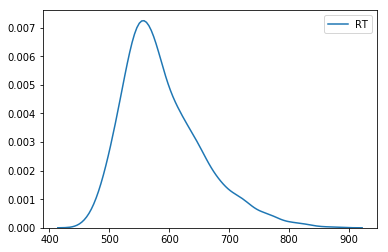

In [19]:
import seaborn as sns
sns.kdeplot(clp_data.RT)

## Prepare dataset

In [20]:
def compute_F(n_compo):
    char_space = Fusiform.CharacterSpace(cv_itos, cv_stoi, cv_vectors, n_components=n_compo)
    char_list = list(common_chars)
    C = [char_space.vectors[char_space.stoi[x]] for x in char_list]
    C = np.vstack(C)
    S = [cwn_vec.embed.vectors[cwn_vec.stoi[x]] for x in char_list]
    S = np.vstack(S)
    CtC = np.dot(C.transpose(), C)
    CtC_inv = np.linalg.inv(CtC)
    F = np.dot(np.dot(CtC_inv, C.transpose()), S)
    recon_S = np.dot(C, F)
    return S, recon_S

In [21]:
def recon_ranks(S, recon_S):      
    recon_err = np.sqrt(np.sum((recon_S - S) ** 2))
    nchar = S.shape[0]
    corr_mat = np.corrcoef(recon_S, S)[nchar:, :nchar]
    recon_ranks = np.diag(corr_mat.argsort(1))
    return (recon_err, corr_mat)

50 391.4461309656602
100 410.8412548332768
150 4989.894554381743


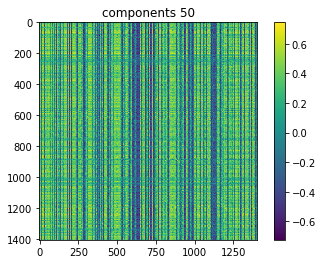

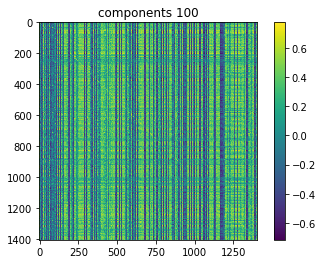

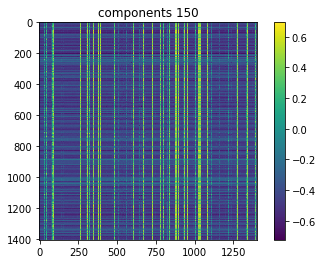

In [24]:
for i in range(50,200,50):
    S, recon_S = compute_F(i)
    err, corr_mat = recon_ranks(S, recon_S)
    print(i, err)
    plt.figure()
    plt.imshow(corr_mat)
    plt.title('components ' + str(i))
    plt.colorbar()    